Описание: Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Исходные данные: Есть датасет с признаками по клиентам пришедших в клуб (пол, место проживания, партнёрство с клубом, использование акции "приведи друга", наличие контактного телефона, возраст, время с первого посещения, длительность абонимента, срок окончания абонемента, факт посещения груповых занятий, частота посещения в неделю, выручка от других услуг фитнеса ) и дана целевая переменная (факт оттока)

Цель проекта: провести анализ и подготовить план действий по удержанию клиентов.

Задачи проекта: научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

In [1]:
!pip install sklearn

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('gym_churn.csv')


## Исследовательский анализ данных (EDA)

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Посмотрим на датасет: есть ли в нем отсутствующие признаки

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Отсутствующих значений нет

In [6]:
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Дубликатов нет

Изучим средние значения и стандартные отклонения

In [7]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


среднее занчение близко к 1 у бинарных признаков признаков: Near_Location, Phone. У остальных бинарных признаков, значение среднего ближе к 0,5.  Длительность текущего действующего абонемента,  у многих пользователей (более половины) он составляет 1 месяц. Возрастная группа примерно с 27 лет до 31 года, отклонения от этого возраста не большие. Средняя частота посещений в неделю 1, 2 раза, разброс в посещениях у пользователей не большой. В выборке, людей выбывших больше чем не выбывших (выбывших примерно 27 процентов)

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [8]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


У обоиз групп равное распределение мужчин и женщин, так же признак Near_Location у обех групп склоняется к 1. У обеих групп почти одинаковый возраст клиентов. У группы которая осталась чаще ходят по партнёрским программам, положительно влияет признак Promo_friends, Contract_period, Group_visits

In [9]:
columns = df.drop(columns=['Churn']).columns
print(len(columns))

13


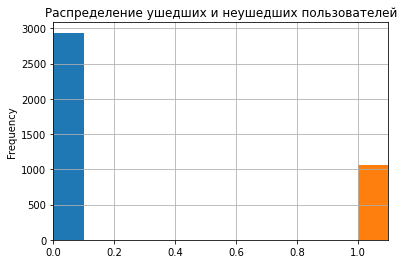

In [10]:
df.query('Churn == 0')['Churn'].plot(kind='hist', label='Остались', grid=True)
df.query('Churn == 1')['Churn'].plot(kind='hist', label='Ушли', grid=True)
plt.title('Распределение ушедших и неушедших пользователей')
plt.xlim(0,1.1)
plt.show()

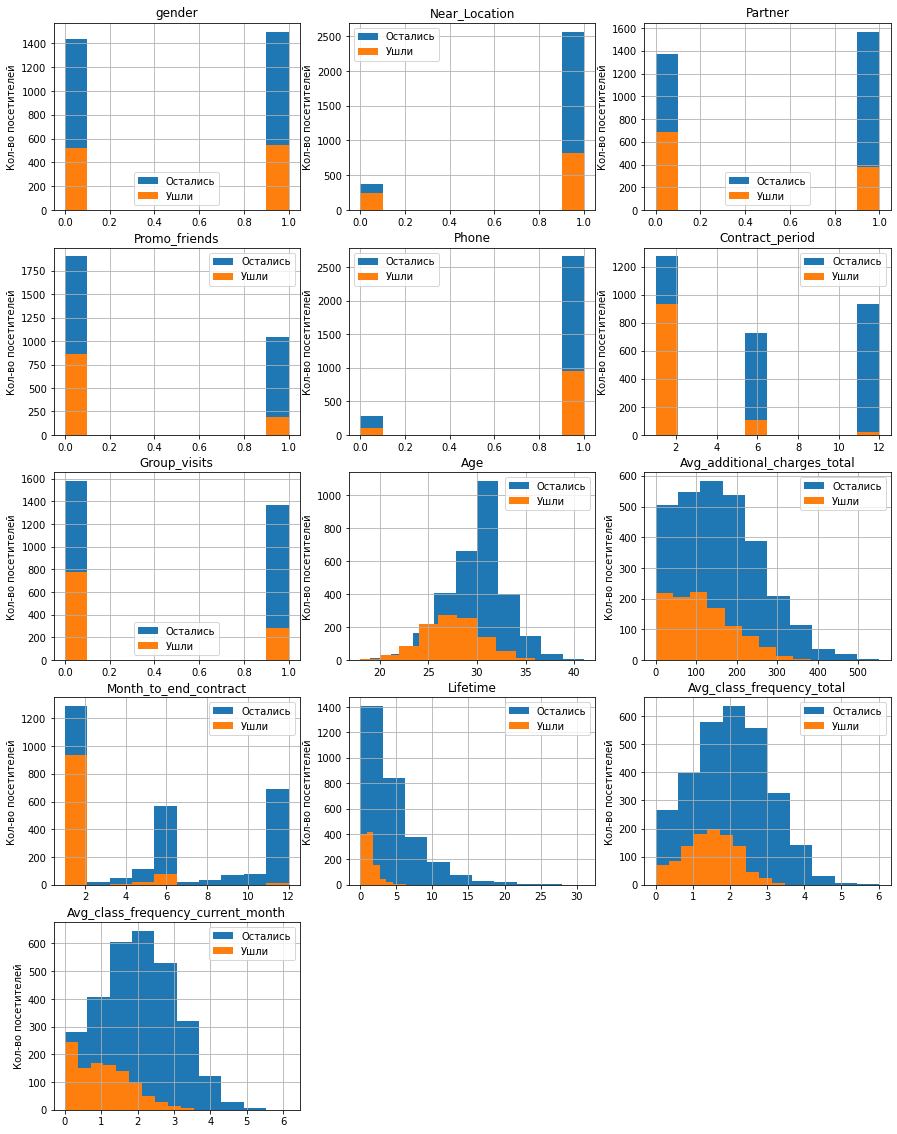

In [11]:
n = 1

plt.figure(figsize=(15, 20))
for x in columns:
    plt.subplot(5,3,n)
    plt.title(x)
    df.query('Churn == 0')[x].plot(kind='hist', label='Остались', grid=True)
    df.query('Churn == 1')[x].plot(kind='hist', label='Ушли', grid=True)
    plt.legend()
    plt.ylabel('Кол-во посетителей')
    n+=1
plt.show()
    

Распределение по признакам, не связанных с временем посещения, близкие. Как уже и отмечалось ранее, люди которые остаются, чаще изначально приходят по акциям от друзей, либюо от партнёрских программ от компаний, а так же можно сделать вывод, если человек уже долго ходит и не уходит, шансы на то что он останется больше


построим матрицу корреляций

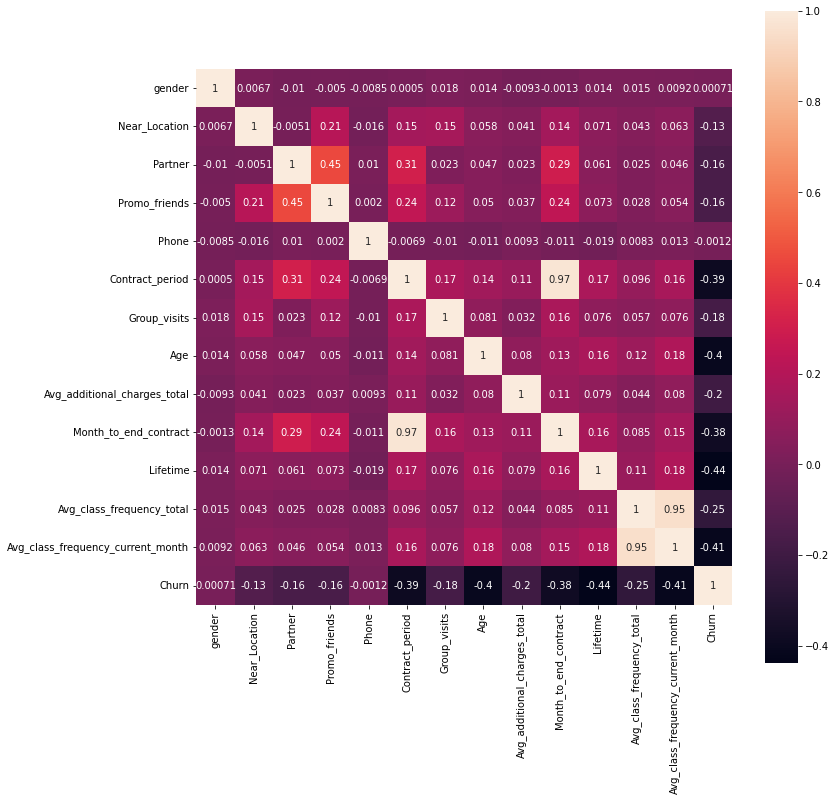

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Из сильно зависящих друг от друга характеристик у нас, Month_to_end_contract и Contract_period, Avg_class_frequency_total и Avg_class_frequency_current_month.
С признаком Churn сильно коррелирующих признаков нет

In [13]:

df = df.drop(columns=['Month_to_end_contract', 'Avg_class_frequency_total'])


## Построение модели прогнозирования оттока клиентов

Разбьём данные на обучающую и валидационную выборку

In [14]:
x = df.drop(columns=['Churn'])
y = df['Churn']

In [15]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.fit_transform(x)


In [16]:
X_train, X_test, y_train,  y_test = train_test_split(x,y, test_size=0.2)

Обучите модель на train-выборке логистической регрессией и случайным лесом

In [17]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)
lr_y = lr_model.predict(X_test)


In [18]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
rf_y = rf_model.predict(X_test)

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [19]:
print(f'Метрика accuracy для логистической регрессии {accuracy_score(y_test, lr_y)}')
print(f'Метрика precision для логистической регрессии {precision_score(y_test, lr_y)}')
print(f'Метрика recall для логистической регрессии {recall_score(y_test, lr_y)}')
print()
print(f'Метрика accuracy для случайного леса {accuracy_score(y_test, rf_y)}')
print(f'Метрика precision для случайного леса {precision_score(y_test, rf_y)}')
print(f'Метрика recall для случайного леса {recall_score(y_test, rf_y)}')



Метрика accuracy для логистической регрессии 0.91125
Метрика precision для логистической регрессии 0.84688995215311
Метрика recall для логистической регрессии 0.8194444444444444

Метрика accuracy для случайного леса 0.90125
Метрика precision для случайного леса 0.8374384236453202
Метрика recall для случайного леса 0.7870370370370371


Логическая регрессия работает лучше по всем метрикам, уровень, предсказаний достаточно хороший.

In [20]:
# дополнение на комментарий ревьюера
# Посмотрим на метрики на тренировочной выборке
lr_train_y = lr_model.predict(X_train)
rf_train_y = rf_model.predict(X_train)

print(f'Метрика accuracy для логистической регрессии {accuracy_score(y_train, lr_train_y)}')
print(f'Метрика precision для логистической регрессии {precision_score(y_train, lr_train_y)}')
print(f'Метрика recall для логистической регрессии {recall_score(y_train, lr_train_y)}')
print()
print(f'Метрика accuracy для случайного леса {accuracy_score(y_train, rf_train_y)}')
print(f'Метрика precision для случайного леса {precision_score(y_train, rf_train_y)}')
print(f'Метрика recall для случайного леса {recall_score(y_train, rf_train_y)}')

Метрика accuracy для логистической регрессии 0.9121875
Метрика precision для логистической регрессии 0.8414043583535109
Метрика recall для логистической регрессии 0.8224852071005917

Метрика accuracy для случайного леса 1.0
Метрика precision для случайного леса 1.0
Метрика recall для случайного леса 1.0


Исходя из тренировочной выборки, видим модель выведенная методом случайного леса, переобучилась все ответы верны (тем не менее на тестовой выборке, её результаты достаточно хороши). можель логической регрессии в целом показала себя хорошо

In [21]:
colom = list(df.drop(columns=['Churn']).columns)
coef = lr_model.coef_
coef = [y for x in coef for y in x]
dframe = pd.DataFrame({'Признаки' : colom, 'Коэффициенты' : coef}).sort_values(by='Коэффициенты', ascending=False)   
print(dframe)
                                           

                             Признаки  Коэффициенты
0                              gender      0.036946
1                       Near_Location     -0.025735
4                               Phone     -0.056173
2                             Partner     -0.062752
3                       Promo_friends     -0.236162
6                        Group_visits     -0.375709
8        Avg_additional_charges_total     -0.591774
7                                 Age     -1.185233
10  Avg_class_frequency_current_month     -1.303301
5                     Contract_period     -1.339742
9                            Lifetime     -3.935016


In [22]:
importances = list(rf_model.feature_importances_)
dframe2 = pd.DataFrame({'Признаки' : colom, 'Пороги' : importances}).sort_values(by='Пороги', ascending=False)   
print(dframe2)

                             Признаки    Пороги
9                            Lifetime  0.315917
10  Avg_class_frequency_current_month  0.211248
7                                 Age  0.152479
8        Avg_additional_charges_total  0.122334
5                     Contract_period  0.107047
6                        Group_visits  0.021786
0                              gender  0.017637
2                             Partner  0.016223
3                       Promo_friends  0.015549
1                       Near_Location  0.012165
4                               Phone  0.007615


In [23]:
df_new = df
total_age_labels = ['Юные(18-26)', 'Молодые(26-28)', 'Средний возраст(28-30)', 'Выше среднего(30-32)', 'Возрастные(32-41)']
df_new['age_group'] = pd.qcut(df['Age'],
                          q=[0, .2, .4, .6, .8, 1],
                          labels=total_age_labels)
print(df_new.pivot_table(index='age_group' , values='Churn', aggfunc='mean'))
print(np.percentile(df_new.Age, [0,20,40,60,80,100]))

                           Churn
age_group                       
Юные(18-26)             0.556220
Молодые(26-28)          0.333333
Средний возраст(28-30)  0.216216
Выше среднего(30-32)    0.115288
Возрастные(32-41)       0.047078
[18. 26. 28. 30. 32. 41.]


## Сделаем кластеризацию клиентов

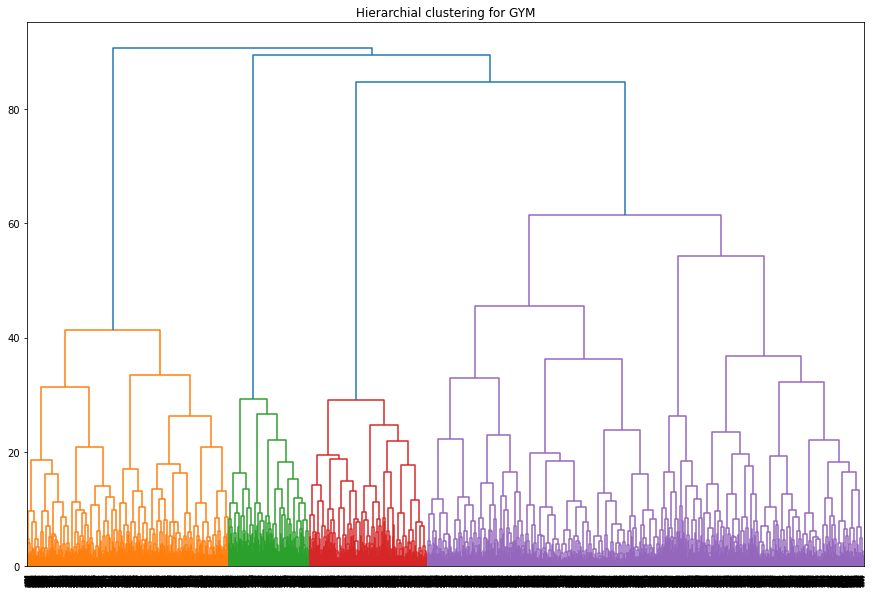

In [24]:
linked = linkage(x, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()


Можно выделить  5 классов

In [25]:
km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(x) 


In [26]:
df['claster'] = labels

In [27]:
df.groupby('claster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
claster,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


In [28]:
# Инфа по всем кластерам (для сравнения)
display(pd.DataFrame(data=[list(df.mean().values.ravel())], columns=list(df.mean().index)))

C:\Users\user\AppData\Local\Temp/ipykernel_15648/626508888.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(pd.DataFrame(data=[list(df.mean().values.ravel())], columns=list(df.mean().index)))


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn,claster
0,0.51025,0.84525,0.48675,0.3085,0.9035,4.68125,0.41225,29.18425,146.943728,3.72475,1.767052,0.26525,1.81275


Общее для кластеров: во всех кластерах равное распределение мужчин/женщин, у всех кластеров примерно равная возрастная категория
1. Первый кластер Near_Location близится к 1 (работают рядом), самый большой приход по партнёрским программам, самый большой показатель Promo_friends, Contract_period, Group_visits, Avg_additional_charges_total, Lifetime и на втором месте  показатель оттока Churn (маленький отток)
2. У второго кластер отличительная черта все входящие в кластер проживают рядом с фитнес центром, они не использовали промокод приведи друга, у них низкие параметры посещения и большой отток
4. У третьего кластер  отличительная черта все входящие в кластер работают рядом с фитнес центром,  плохие характеристики посещений, и самый большой отток, низкий приход по партнёрским программам, и по акции приведи друга
5. У четвёртого кластера  самый низкий отток, кластер Near_Location близится к 1 (работают рядом), высокий уровень посещаемости.
5. Пятый кластер не оставлял контактного телефона, а в остальном, все характеристики для этого кластера, средние

Посчитаем долю оттока у кластеров

In [29]:
clasters = df.groupby('claster')['Churn'].sum() / df.groupby('claster')['Churn'].count()
clasters.index = [i for i in range(1,6)]
clasters

1    0.119797
2    0.403226
3    0.563910
4    0.014896
5    0.266839
Name: Churn, dtype: float64

Самая большая доля оттока у 4-го класса, на втором месте у третьего класса, у второго класса средняя доля оттока. У 1 и пятого потока отток на достаточно низком хорошем уровне.


In [30]:
column = list(df.columns) #.remove('claster')
column.remove('claster')
column.remove('age_group')
# column

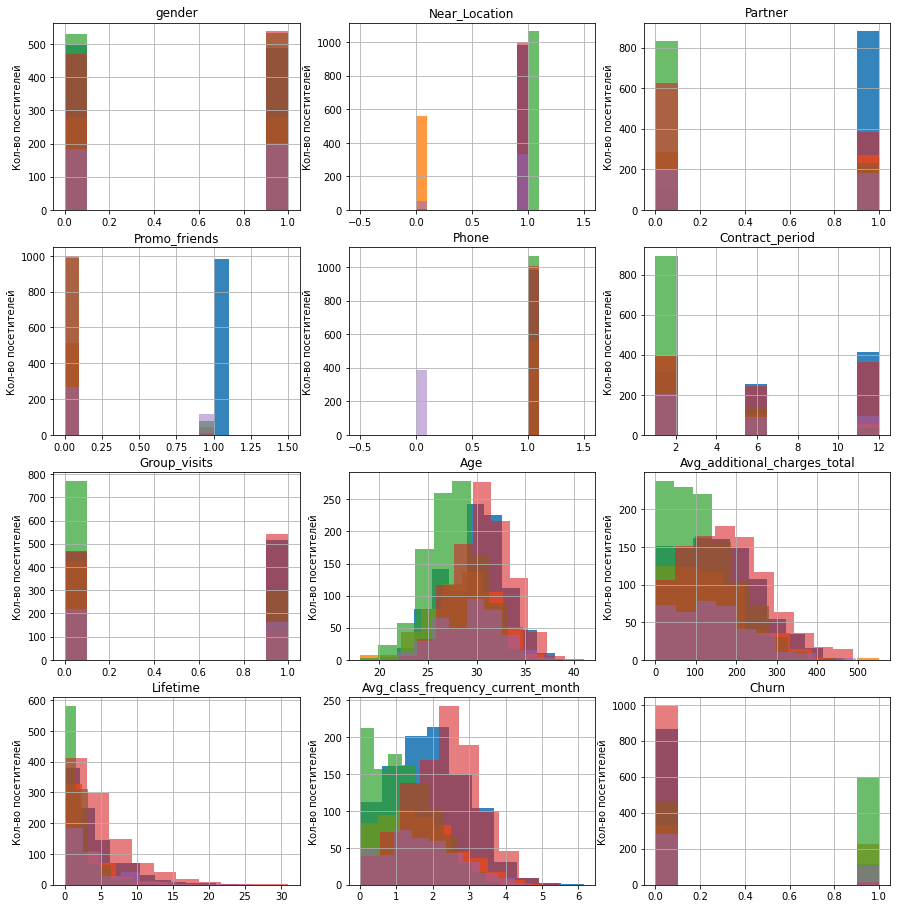

In [31]:
n = 1
plt.figure(figsize=(15, 20))
for x in column:
    plt.subplot(5,3,n)
    plt.title(x)
    a=1
    for p in range(0, 5):
        a-=0.1
        df.query('claster == @p')[x].plot(kind='hist', label=f'Кластер {p}', grid=True, alpha=a)
    plt.ylabel('Кол-во посетителей')
    n+=1
plt.show()
    

если смотреть распределение по одному признаку, видим что распределение у кластеров, часто совпадают, кластеры чаще отличаются по бинарным признакам, если мы берём признаки целочисленные, то тутесть кластеры которые выделяются,но мнигие имеют похожие распределения

Построим матрицу распределения признаков по кластерам

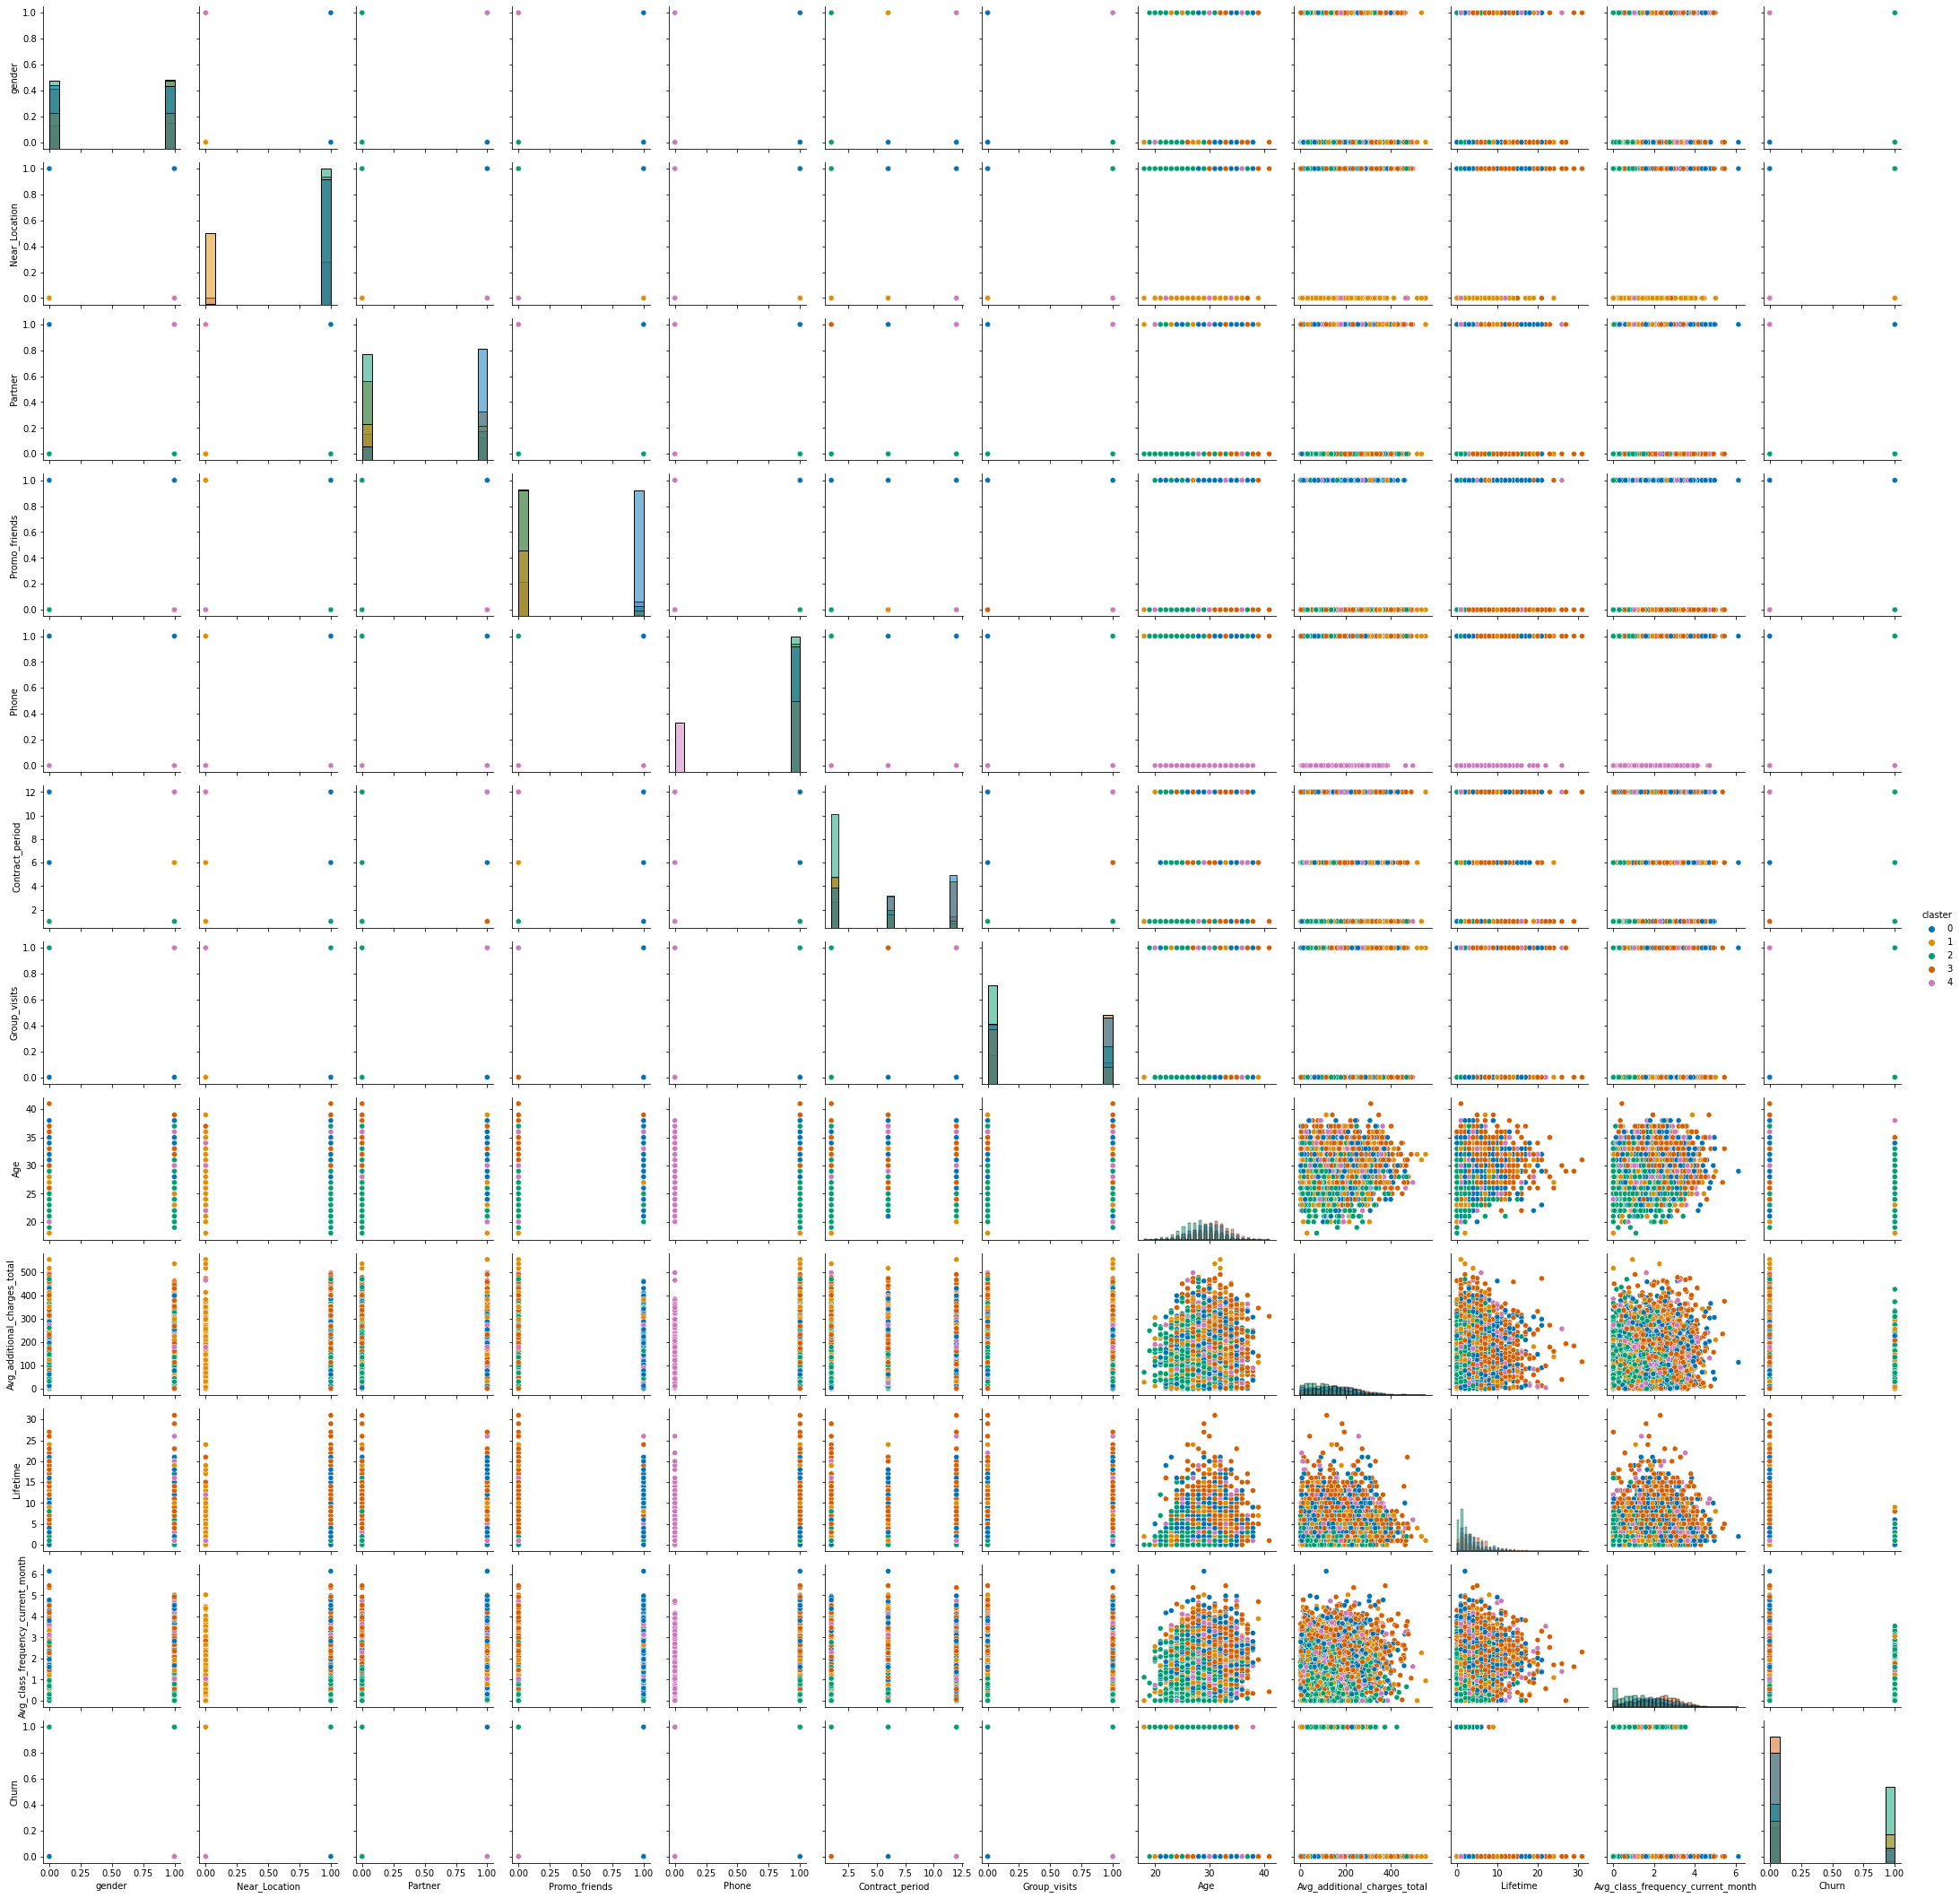

In [32]:
g = sns.PairGrid(df, hue="claster", palette='colorblind')
sns.color_palette()
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

По сочетанию двух признаков, деление на кластеры, сложно, и мало где явно отличимо, как было уже написано ранее, кластеры отделимы на бинарных признаках (мужчина/женчина, рядом_дом/рядом_работаб и т.д)

## Выводы

1. Среднее занчение близко к 1 у бинарных признаков признаков: Near_Location, Phone. У остальных бинарных признаков, значение среднего ближе к 0,5. Длительность текущего действующего абонемента, у многих пользователей (более половины) он составляет 1 месяц. Возрастная группа примерно с 27 лет до 31 года, отклонения от этого возраста не большие. Средняя частота посещений в неделю 1, 2 раза, разброс в посещениях у пользователей не большой. В выборке, людей выбывших больше чем не выбывших (выбывших примерно 27 процентов)

2. Распределение по признакам, не связанных с временем посещения, близкие. Как уже и отмечалось ранее, люди которые остаются, чаще изначально приходят по акциям от друзей, либюо от партнёрских программ от компаний, а так же можно сделать вывод, если человек уже долго ходит и не уходит, шансы на то что он останется больше

3. Из сильно зависящих друг от друга характеристик у нас, Month_to_end_contract и Contract_period, Avg_class_frequency_total и Avg_class_frequency_current_month. С признаком Churn сильно коррелирующих признаков нет

4. Логическая регрессия работает лучше по всем метрикам, уровень, предсказаний достаточно хороший.

5. Было выделено пять кластеров. Общее для кластеров: во всех кластерах равное распределение мужчин/женщин, у всех кластеров примерно равная возрастная категория

    1. Первый кластер Near_Location близится к 1 (работают рядом), самый большой приход по партнёрским программам, самый большой показатель Promo_friends, Contract_period, Group_visits, Avg_additional_charges_total, Lifetime и на втором месте  показатель оттока Churn (маленький отток)
    
    2. У второго кластер отличительная черта все входящие в кластер проживают рядом с фитнес центром, они не использовали промокод приведи друга, у них низкие параметры посещения и большой отток
    
    3. У третьего кластер  отличительная черта все входящие в кластер работают рядом с фитнес центром,  плохие характеристики посещений, и самый большой отток, низкий приход по партнёрским программам, и по акции приведи друга
    
    4. У четвёртого кластера  самый низкий отток, кластер Near_Location близится к 1 (работают рядом), высокий уровень посещаемости.
    
    5. Пятый кластер не оставлял контактного телефона, а в остальном, все характеристики для этого кластера, средние

### Рекомендации

Наиболее важные признаки, которые следует мониторить, и в первую очередь улучшать, 
1. частота посещений -  увеличивая этот показатель, уменьшается вероятность оттока (возможны скидочные программы пакетно увеличивающие количество походов в зал, за скидку в расчёте на одно посещение)
2. Видно и влияние возраста на целевую переменную, следовательно необходимо ориентироваться, на средний возраст клиентов, как показывает практика чем выше возраст, тем меньше вероятность оттока.
3. Низкий отток у пользователей которые прихдят по промо от друзей, хорошо будет продолжать развивать эту программу
4. Так же программа направленная на партнёрство хорошо сработала на пользователях которые, работаю рядом с клубом, хорошо будет продолжать развивать эту программу.